## The Power Socket Problem

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

### Stochastic Power Socket

In [2]:
class PowerSocket:
    def __init__(self, q):                
        self.q = q   # the true reward value                
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried
    
    # the reward is a random distribution around the initial mean value set for this socket
    # - never allow a charge less than 0 to be returned
    def charge(self):
        # a guassian distribution with unit variance around the true value 'q'
        value = np.random.randn() + self.q        
        return 0 if value < 0 else value
                    
    # increase the number of times this socket has been used and improve the estimate of the 
    # value (the mean) by combining the new reward 'r' with the current mean
    def update(self,R):
        self.n += 1

        # the new estimate is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

### Power Socket Testing

- create 5 sockets and examine what they return

In [3]:
# If FIXED_SOCKET_ORDER is set true then 5 sockets will be created with the same mean values as described in the Medium article.
# Otherwise, the specified number of sockets will be created with mean values that are assigned in a random order 
# (so the output of each socket can be different on each run).
FIXED_SOCKET_ORDER = True
NUM_SOCKETS = 5

# check that there are only 5 sockets if fixed socket ordering is being used
assert FIXED_SOCKET_ORDER == False or NUM_SOCKETS == 5, "When using a fixed socket order the number of sockets must be set to 5"

# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket 
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# create the order in which socket mean reward will be allocated
socket_order = []
if FIXED_SOCKET_ORDER:
    # create 5 sockets in a fixed order
    socket_order = [2,1,3,5,4]
else:
    # create the specified number of sockets in a random order 
    socket_order = random.sample(range(1,1+NUM_SOCKETS), NUM_SOCKETS)
    
print( f'Creating sockets with the order of increasing reward: {socket_order}')    

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]
# sockets = [PowerSocket((q)+4) for q in socket_order]

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):
    
    # get charge from the socket for the defined number of steps   
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()                

Creating sockets with the order of increasing reward: [2, 1, 3, 5, 4]


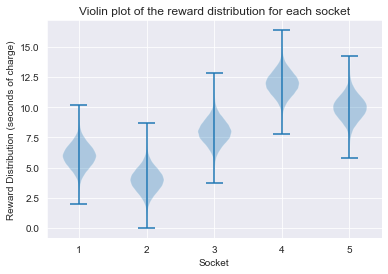

In [4]:
# plot the charge we got from the sockets           
plt.violinplot(rewards)   
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.title('Violin plot of the reward distribution for each socket')
plt.savefig('violin_plot.png')
plt.show() 

### Density Plots of the Socket Outputs

A density plot is a smoothed, continuous, version of a histogram estimated from the data.
The y-axis represents the probability density function of the socket.
The plot shows the relative outputs of each socket.
(see https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0 for more details on probability density functions)

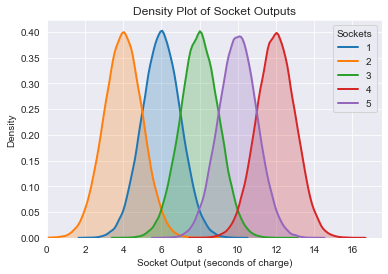

In [5]:
# iterate through the sockets to draw each plot
# (from: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');
    
# Plot formatting
plt.xlim(0, None)
plt.legend(title = 'Sockets')
plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')
plt.savefig("density_plot.png")

We could generate a similar plot just using histograms and splitting the output from each socket into a set of bins, where each bin would add up the number of outputs in that bin.

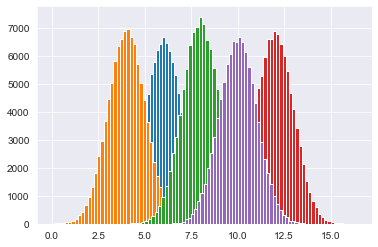

<Figure size 432x288 with 0 Axes>

In [6]:
for socket_number in range(NUM_SOCKETS):
    plt.hist(rewards[:,socket_number], bins=50)
plt.show()
plt.savefig('hist.png')




## Bandit Algorithms

### Optimistic-Greedy

In the Optimistic Greedy algorithm we want to set the initial estimates for each socket to a large value.


(NOTE: We'll reuse the sockets that have already been created, so their respective rewards should remain the same as the outputs shown above)

Initially set the estimate for each socket to a large value and initialize its count of the number of times the socket has been tried to 1 

In [7]:
# Create an Optimistic Power Socket class by inheriting from the standard Power Socket
class OptimisticPowerSocket( PowerSocket ):
    def __init__(self, q, initial_estimate ):    
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)        
        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = initial_estimate                 
        
        # the number of times this socket has been tried 
        # - set to 1 to take account of the initialisation
        self.n = 1             

In [8]:
# test the maximum value from the sockets
np.amax(rewards)

16.38222270829845

In [9]:
# the maximum charge is around 16 seconds worth (for 5 sockets), therefore setting our initial estimates to 20 should be large enough
INITIAL_ESTIMATE = 20.

# create the optimistic sockets with the same order as the previous standard sockets
sockets = [OptimisticPowerSocket((q*2)+2, INITIAL_ESTIMATE) for q in socket_order]

In [10]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [11]:
# reduced number of time steps
TOTAL_STEPS = 30                 
    
# save data about the run to create a table of estimates
estimates = np.zeros(shape=(TOTAL_STEPS+1,NUM_SOCKETS))

# set the first estimates to be the initial value
estimates[0] = INITIAL_ESTIMATE 
    
    
# loop for the specified number of time-steps
for t in range(TOTAL_STEPS):

    # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie    
    socket_index = random_argmax([socket.Q for socket in sockets])

    # charge from the chosen socket and update its mean reward value
    reward = sockets[socket_index].charge()
    sockets[socket_index].update(reward)

    # store the estimates of each socket at this time step
    for socket_number in range(NUM_SOCKETS):
        estimates[t+1,socket_number] = sockets[socket_number].Q        

# show the estimates as a Pandas dataframe for better display
df = pd.DataFrame(estimates)

# rename the columns to be 1-based
df.columns = [1,2,3,4,5]

In [12]:
# show the true values of each socket so we can display the maximum value
socket_means = [((q*2)+2) for q in socket_order]
socket_means

[6, 4, 8, 12, 10]

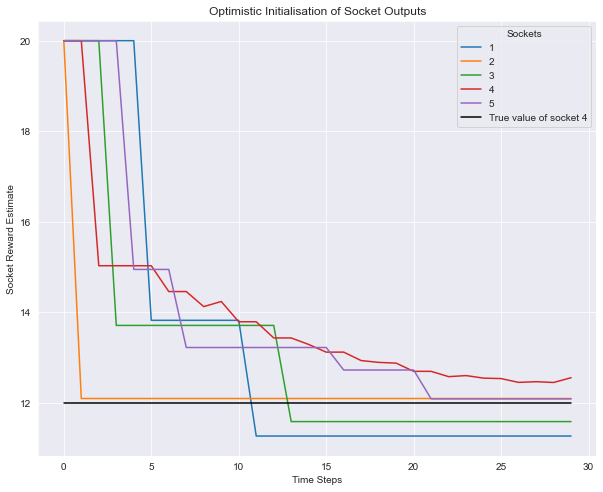

In [14]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')       

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

plt.savefig("optimistic_initialisation.png")

In [15]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()            
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):   
    '''
    highlight the entry before the column value changes
    '''    
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')    
    return style

In [16]:
# show the estimates of each socket, highlighting the socket that has been selected for each time step
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20.000000,20.000000,20.000000,20.000000,20.000000
1,20.000000,12.094680,20.000000,20.000000,20.000000
2,20.000000,12.094680,20.000000,15.027888,20.000000
3,20.000000,12.094680,13.709569,15.027888,20.000000
4,20.000000,12.094680,13.709569,15.027888,14.946415
5,13.822184,12.094680,13.709569,15.027888,14.946415
6,13.822184,12.094680,13.709569,14.457687,14.946415
7,13.822184,12.094680,13.709569,14.457687,13.221607
8,13.822184,12.094680,13.709569,14.125106,13.221607
9,13.822184,12.094680,13.709569,14.238422,13.221607


In [253]:
# convert the dataframe to 3 decimal places
# df = df.applymap(lambda x: '{0:.3f}'.format(x))

# np.round(df[0:5],decimals=3)


df.columns = [1,2,3,4,5]

In [17]:
small_df = df[1:6]
# pd.set_option('precision', 4)

# pd.reset_option('^display.', silent=True)
pd.reset_option('precision', silent=True)

styler = df.style
# styler = styler.format("{:,.3f}")
# styler = styler.set_properties(**{'width': '200px', 'text-align': 'right'})

styler.set_table_styles(
# select the table header with th and set it right align
    [dict(selector="th", props=[("text-align", "right")])]   
)

# from pandas import option_context

# with option_context('display.colwidth', 300):
display(small_df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=small_df.index[-1]))

,1,2,3,4,5
1,20.000000,12.094680,20.000000,20.000000,20.000000
2,20.000000,12.094680,20.000000,15.027888,20.000000
3,20.000000,12.094680,13.709569,15.027888,20.000000
4,20.000000,12.094680,13.709569,15.027888,14.946415
5,13.822184,12.094680,13.709569,15.027888,14.946415


In [18]:
small_df = df[26:32]
small_df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=small_df.index[-1])

,1,2,3,4,5
26,11.265726,12.094680,11.584670,12.450666,12.086456
27,11.265726,12.094680,11.584670,12.466418,12.086456
28,11.265726,12.094680,11.584670,12.448621,12.086456
29,11.265726,12.094680,11.584670,12.554179,12.086456
30,11.265726,12.094680,11.584670,12.491742,12.086456


In [20]:
import imgkit

# write the table for the first 20 time steps to an image
small_df = df[0:21]
html = small_df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=small_df.index[-1]).render()
imgkit.from_string(html, f'Optimistic/full.png', options = {'crop-w':'400'})    

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

### Create an animated version of the table

In [21]:
ROWS_PER_TABLE = 11

# create an array of data frames of ROWS_PER_TABLE rows each
X = [df[i:i+ROWS_PER_TABLE] for i in range(df.shape[0]-ROWS_PER_TABLE+1)] 

# write each table as an image to the "Optimistic" folder
from pathlib import Path
Path("./Optimistic").mkdir(parents=True, exist_ok=True)

for i in range(df.shape[0]-ROWS_PER_TABLE+1):
    html = X[i].style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=X[i].index[-1]).render()
    imgkit.from_string(html, f'Optimistic/{i+1}.png', options = {'crop-w':'400'})    

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                    

In [22]:
# create an animated gif from the images
from PIL import Image, ImageDraw

images = []
# for i in range(df.shape[0]-ROWS_PER_TABLE+1):
for i in range(21):    
    images.append(Image.open(f'Optimistic/{i+1}.png'));

images[0].save('OptimisticSocket.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=350, loop=0)

In [224]:
# import os
# def save():
# #     os.system("ffmpeg -r 1 -i img%01d.png -vcodec mpeg4 -y movie.mp4")
#     os.system("ffmpeg -r 4 -i /Optimistic/%01d.png -vcodec mpeg4 -y movie.mp4")
    
# save()    

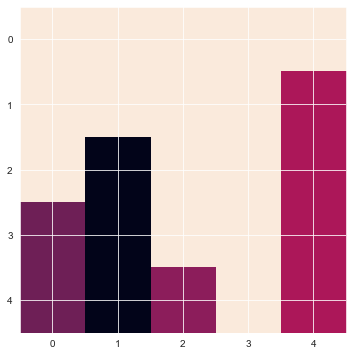

In [450]:
# import matplotlib.pyplot as plt
import matplotlib.animation
# import numpy as np; np.random.seed(1)
# import pandas as pd

# X = [pd.DataFrame(np.random.rand(10,10)) for i in range(100)] 
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(X[0],interpolation='nearest')

def update_img(n):
    im.set_data(n.values)

ani = matplotlib.animation.FuncAnimation(fig,update_img, frames = X, interval=30)

FFwriter = matplotlib.animation.FFMpegWriter(fps=30)     
ani.save("dataframe_animation"+".mp4",writer = FFwriter)

plt.show()

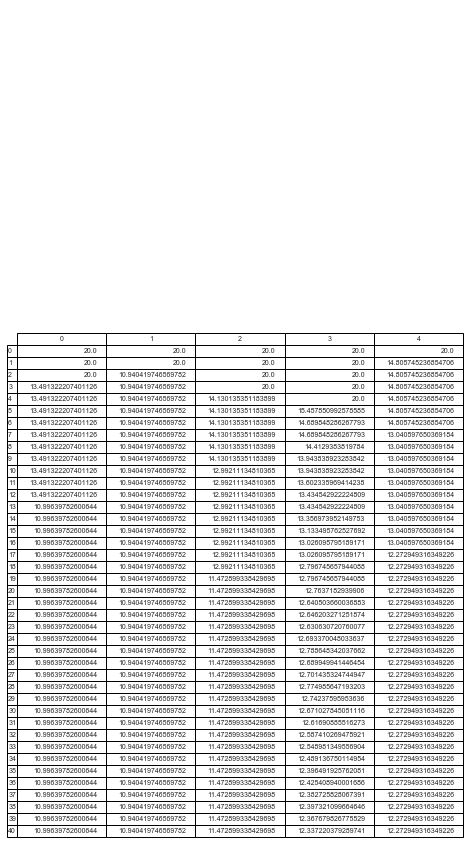

In [439]:
from pandas.plotting import table 

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df)  # where df is your data frame

plt.savefig('mytable.png')

In [338]:
# cumulative_average = np.cumsum(rewards) / (np.arange(TOTAL_STEPS)+1)

# # plot moving average
# plt.plot(cumulative_average)
# # plt.plot(np.ones(N)*m1)
# # plt.plot(np.ones(N)*m2)
# # plt.plot(np.ones(N)*m3)
# # plt.xscale('log')
# plt.show()

# for b in bandits:
#     print( b.Q )

# print(f'final cumulative reward = {cumulative_average[N-1]}')  

In [53]:
# from: https://peterroelants.github.io/posts/multi-armed-bandit-implementation/

# Imports
%matplotlib inline

import sys
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
#

In [37]:
nb_bandits = 3  # Number of bandits
# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]


def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

In [38]:
# Iterations to plot
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]


def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')
#

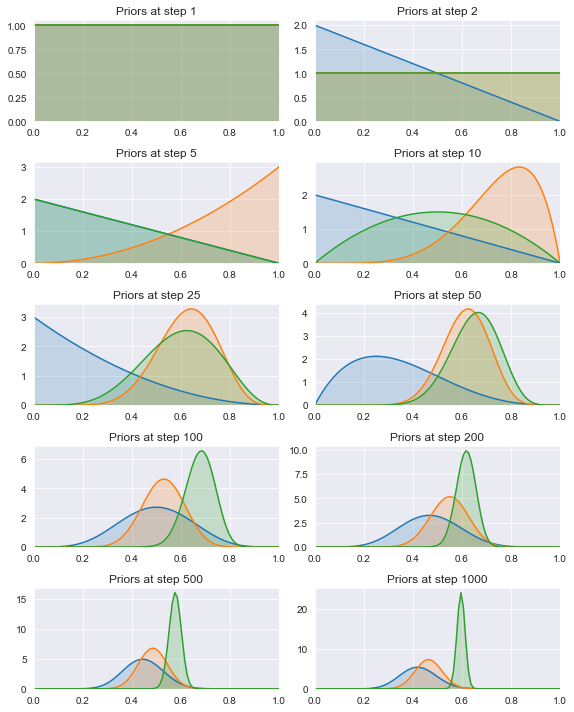

In [39]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trial for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()

In [40]:
num_sockets = 5

def socket_test(total_steps,eps):
    
    # create the specified number of sockets with unique random mean values from 1 to the number of sockets
    sockets = [PowerSocket(q) for q in random.sample(range(1,1+num_sockets), num_sockets)]

    # save data about the run to create graphs
    rewards = np.empty(total_steps)

    # loop for the chosen number of time-steps
    for t in range(total_steps):

        # probability of pulling a bandit at random
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < eps:
            index = np.random.choice(num_sockets)
        else:
            # choose the socket with the current highest mean reward
            index = np.argmax([socket.Q for socket in sockets])

        # charge from the chosen socket and update its estimated reward value
        reward = sockets[index].charge()
        sockets[index].update(reward)

        # store the reward from this time-step
        rewards[t] = reward

    return rewards    

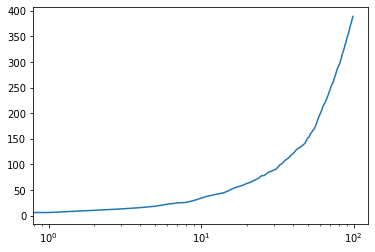

In [4]:
total_steps = 100

rewards = socket_test(total_steps,0.1)
cumulative_average = np.cumsum(rewards) / (np.arange(total_steps)+1) 


# plot total reward
plt.plot(np.cumsum(rewards))
plt.xscale('log')
plt.show()

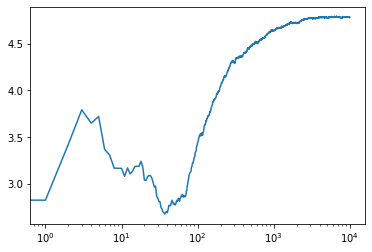

In [5]:
total_steps = 10000

rewards = socket_test(total_steps,0.1)
cumulative_average = np.cumsum(rewards) / (np.arange(total_steps)+1) 

# plot moving average
plt.plot(cumulative_average)
plt.xscale('log')
plt.show()

# for b in bandits:
#     print( b.mean )

# print(f'final cumulative reward = {cumulative_average[N-1]}')